In [6]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
Device Name: NVIDIA GeForce RTX 3080 Laptop GPU


# Загрузка данных

In [7]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv('dataset/amazon_reviews_small.csv')
df = df[['category','reviewText', 'class']]
df_class_0 = df[df['class'] == 0].sample(n=10000, random_state=42)
df_class_1 = df[df['class'] == 1].sample(n=10000, random_state=42)
df = pd.concat([df_class_0, df_class_1])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = shuffle(df).reset_index(drop=True)

# Функции и классы для предобработки и обучения

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    words = text.split()
    doc = nlp(" ".join(words))
    words = [token.lemma_ for token in doc]
    return " ".join(words)

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, TrainerCallback
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from transformers import EarlyStoppingCallback


In [10]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [14]:
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.val_losses.append(logs['eval_loss'])

    def get_losses(self):
        return self.train_losses, self.val_losses

def train_model(dataset, tokenizer, model_name='bert-base-uncased', batch_size=512, epochs=10, dropout_prob=0.2, max_length=256):
    train_texts, val_texts, train_labels, val_labels = train_test_split(dataset['reviewText'], dataset['class'], test_size=0.2)

    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    train_dataset = SpamDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = SpamDataset(val_texts, val_labels, tokenizer, max_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    model.config.attention_probs_dropout_prob = dropout_prob
    model.config.hidden_dropout_prob = dropout_prob
    for param in model.bert.parameters():
        param.requires_grad = False
    for param in model.bert.encoder.layer[-1].parameters():
        param.requires_grad = True

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch", 
        logging_dir='./logs',
        logging_strategy="epoch",
        save_total_limit=2,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss"
    )

    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

    loss_logging_callback = LossLoggingCallback()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        callbacks=[loss_logging_callback, early_stopping_callback]
    )

    trainer.train()

    predictions, labels, metrics = trainer.predict(val_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels)
    accuracy = accuracy_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels)
    metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'F1 Score'],
    'Score': [precision, recall, accuracy, f1]
    })
    table = tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', showindex=False)
    print(table)

    conf_matrix = confusion_matrix(labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    train_losses, val_losses = loss_logging_callback.get_losses()
    print(train_losses)
    print(val_losses)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Обучение при разном размере батча

## batch_size = 16

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_8128\100883073.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.355100,0.301660
2,0.290600,0.342092
3,0.266000,0.291394
4,0.240100,0.282459
5,0.221000,0.291969
6,0.200100,0.328109
7,0.178500,0.325122


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.897149 │
├───────────┼──────────┤
│ Recall    │ 0.884538 │
├───────────┼──────────┤
│ Accuracy  │ 0.892    │
├───────────┼──────────┤
│ F1 Score  │ 0.890799 │
╘═══════════╧══════════╛


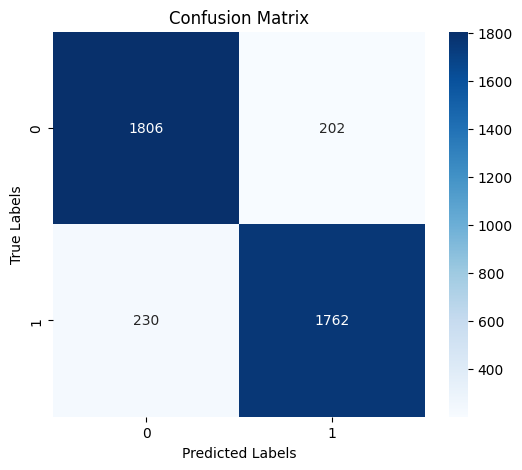

[0.3551, 0.2906, 0.266, 0.2401, 0.221, 0.2001, 0.1785]
[0.3016603887081146, 0.3420921862125397, 0.29139411449432373, 0.2824593782424927, 0.2919687330722809, 0.3281089663505554, 0.32512158155441284]


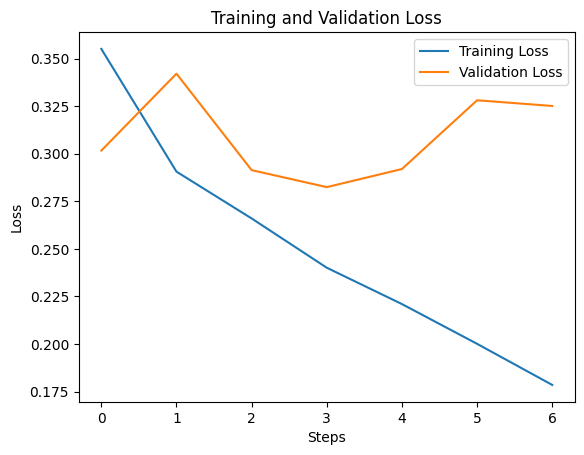

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_model(df, tokenizer, batch_size = 16)

## batch_size = 32

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_8128\100883073.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.367600,0.306587
2,0.293500,0.286895
3,0.270000,0.286486
4,0.253300,0.306294
5,0.233600,0.290863
6,0.214900,0.291286


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.897733 │
├───────────┼──────────┤
│ Recall    │ 0.869693 │
├───────────┼──────────┤
│ Accuracy  │ 0.8825   │
├───────────┼──────────┤
│ F1 Score  │ 0.88349  │
╘═══════════╧══════════╛


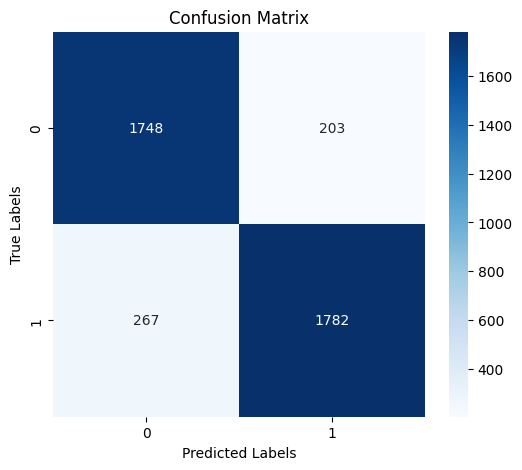

[0.3676, 0.2935, 0.27, 0.2533, 0.2336, 0.2149]
[0.3065870404243469, 0.2868950068950653, 0.2864861488342285, 0.306293785572052, 0.2908627986907959, 0.29128628969192505]


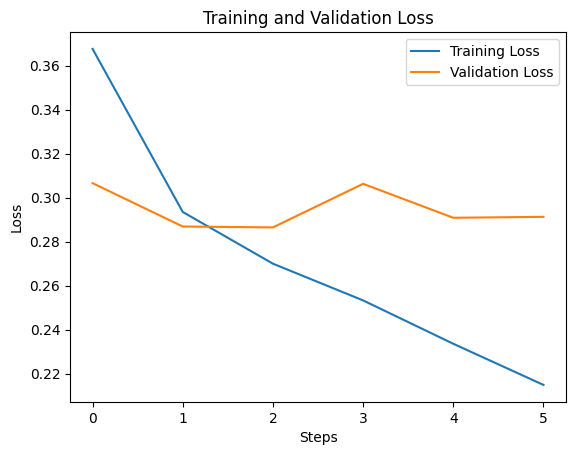

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_model(df, tokenizer, batch_size = 32)

## batch_size = 64

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_8128\100883073.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.386100,0.308329
2,0.300000,0.288683
3,0.282000,0.284831
4,0.263000,0.274665
5,0.245700,0.282898
6,0.231300,0.279751
7,0.221800,0.274666


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.887269 │
├───────────┼──────────┤
│ Recall    │ 0.891166 │
├───────────┼──────────┤
│ Accuracy  │ 0.88625  │
├───────────┼──────────┤
│ F1 Score  │ 0.889214 │
╘═══════════╧══════════╛


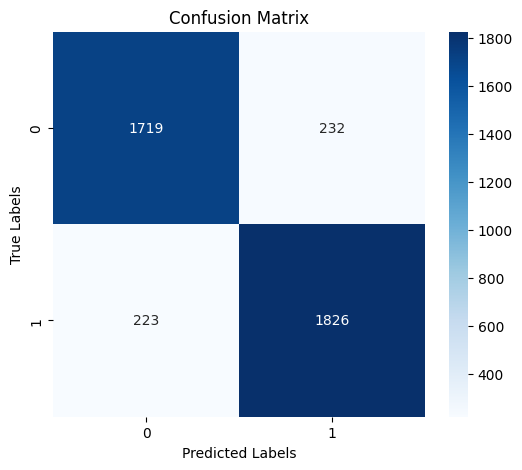

[0.3861, 0.3, 0.282, 0.263, 0.2457, 0.2313, 0.2218]
[0.3083289861679077, 0.2886825501918793, 0.2848305106163025, 0.2746652364730835, 0.2828975021839142, 0.27975085377693176, 0.2746657133102417]


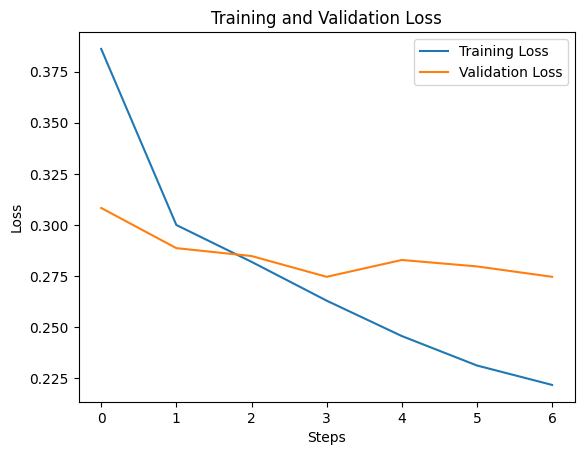

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_model(df, tokenizer, batch_size = 64)